In [ ]:
import sys
sys.path.append("../src")
import lightbeam
from lightbeam.mesh import RectMesh3D, RectMesh2D
import lightbeam.optics as optics
from lightbeam import LPmodes
from lightbeam.misc import normalize
from lightbeam.prop import Prop3D

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

In [ ]:
# wavelength: 1.5 um
# background (capillary) index: 1.4345
# SM cladding index: 1.44
# SM core index: 1.4522895
# T (taper ratio): 10
# Cladding output diameter: 328 um
# Cladding input diameter: 32.8 um (ie 328/T)
# SM core diam: 6.5 um
# SM core separation (on hex grid): 60 um

wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_final = 2*60 # um
# # what is MM core radius assuming 2 um from http://dx.doi.org/10.1364/AOP.7.000107, 
# # measurements of figure 6 c): 570, 105
# mm_rcore = 28 # um ROUGH GUESS
sm_offset = 100
sm_ex = 5000
scale_func = None
l = 2
m = 2

In [ ]:
xw = 100 #um
yw= 100 #um
zw = sm_ex #um
num_PML = 10 #grid units

ds = 0.5 #um
dz = 10 #um

_mesh = RectMesh3D(xw,yw,zw,ds,dz,num_PML)
_mesh.xy.plot_mesh()

In [ ]:
lant19_ipos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final/taper_ratio)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,sm_offset,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics.scaled_cyl(xy=lant19_ipos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=sm_offset,scale_func=scale_func,final_scale=taper_ratio) # fxy=lant19_fpos[i]
    elmnts.append(core)

lant19 = optics.OpticSys(elmnts,njack)
lant19.set_sampling(_mesh.xy)

out1 = np.zeros(_mesh.xy.shape)

# fig, axs = plt.subplots(1, 1, figsize=(7.5,7.5))
# ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor='lightgoldenrodyellow')
# slider = Slider(ax_slider, 'Z value', 0, sm_ex, valinit=0, valstep=1)

# lant19.set_IORsq(out, 0)
# im = axs.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
# axs.set_title(f"z = 0")
# # Define the update function for the slider
# def update(val):
#     z_value = int(slider.val)
#     out = np.zeros(_mesh.xy.shape)
#     lant19.set_IORsq(out, z_value)
#     im.set_data(out)
#     axs.set_title(f"z = {z_value}")
#     fig.canvas.draw_idle()

# # Attach the update function to the slider
# slider.on_changed(update)

# plt.show()

# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Generate the first subplot
lant19.set_IORsq(out1, 0)
lims = [500,800]
# axs[0].set_xlim(lims)
# axs[0].set_ylim(lims)
# axs[0].set_xlabel('"Zoomed in"')
axs[0].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
axs[0].set_title(f"Multimode input || z = 0 to {sm_offset}")

# Generate the second subplot
lant19.set_IORsq(out1, sm_offset)
# axs[1].set_xlim(lims)
# axs[1].set_ylim(lims)
# axs[1].set_xlabel('"Zoomed in"')
axs[1].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
axs[1].set_title(f"Single mode before taper || z = {sm_offset}")

# # Generate the third subplot
# lant19.set_IORsq(out1, sm_ex)
# axs[2].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
# axs[2].set_title(f"Single mode output || z = {sm_ex}")
# # Display the figure with the subplots
# plt.tight_layout()
# plt.show()

#_mesh.xy.plot_mesh()

In [ ]:
import lightbeam.LPmodes as LPmodes
from lightbeam.misc import normalize

xg, yg = _mesh.xg[num_PML:-num_PML,num_PML:-num_PML],_mesh.yg[num_PML:-num_PML,num_PML:-num_PML]
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
u1 = normalize(LPmodes.lpfield(xg,yg,4,4,mm_rclad,wl,nclad,njack))
u2 = normalize(LPmodes.lpfield(xg,yg,1,2,mm_rclad,wl,nclad,njack))

print(u0[0,0])
print((0+1j)*u0[0,0])

plt.imshow(np.abs((1+0j)*u0 + (1+0j)*u1 + (1+0j)*u2))
plt.show()
print("input field: ")
plt.imshow(np.abs(u0))
plt.show()

#### propagation ####

from lightbeam.prop import Prop3D

prop = Prop3D(wl,_mesh,lant19,nclad)

In [ ]:
u0 = prop.prop2end(u0)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
print("output field: ")
plt.imshow(np.abs(u0))
plt.show()

**Seperating the light propogation between the different meshes for each object**


In [ ]:
# wavelength: 1.5 um
# background (capillary) index: 1.4345
# SM cladding index: 1.44
# SM core index: 1.4522895
# T (taper ratio): 10
# Cladding output diameter: 328 um
# Cladding input diameter: 32.8 um (ie 328/T)
# SM core diam: 6.5 um
# SM core separation (on hex grid): 60 um
%matplotlib inline
wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_initial = 2*sm_rcore # um
sm_seperation_final = 2*60 # um TEMP
sm_offset = 100
sm_ex = 40000
scale_func = None
ref_val = 2e-4
l = 2
m = 2

In [ ]:
ds = 0.5 #um
dz = 0.5 #um
iw = 100 #um
zw = sm_offset #um
num_PML = round(mm_rclad) #grid units

_mesh = RectMesh3D(iw,iw,zw,ds,dz,num_PML)
_mesh.xy.plot_mesh()

clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)

mm = optics.OpticSys([clad_mm],njack)

xg, yg = _mesh.xg,_mesh.yg
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
print(f"xg shape: {xg.shape}")
print(f"yg shape: {yg.shape}")
print(f"u0 shape: {u0.shape}")

print("input field: ")
plt.imshow(np.abs(u0))
plt.show()
# _mesh.xy.refine_base(u0,ref_val)
# mm.set_sampling(_mesh.xy)
_mesh.xy.plot_mesh()
prop = Prop3D(wl,_mesh,mm,njack)
u0 = prop.prop2end_uniform(u0)
print("output field: ")
plt.imshow(np.abs(u0))
plt.show()

In [ ]:
ds = 0.8 #um
dz = 10 #um
iw = 600 #um
zw = sm_ex #um
num_PML = 70 #grid units

_mesh = RectMesh3D(iw,iw,zw,ds,dz,num_PML)

lant19_ipos = optics2.lant19.get_19port_positions(core_spacing=sm_seperation_initial)
lant19_fpos = optics2.lant19.get_19port_positions(core_spacing=sm_seperation_final)

#lant19pos = optics.lant19.get_19port_positions(core_spacing=sm_rcore)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_ex,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,0,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics2.scaled_cyl(xy=lant19_ipos[i],fxy=lant19_fpos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=0,scale_func=scale_func,final_scale=taper_ratio)
    elmnts.append(core)

lant19 = optics.OpticSys(elmnts,njack)
lant19.set_sampling(_mesh.xy)

out = np.zeros(_mesh.xy.shape)
# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Generate the first subplot
lant19.set_IORsq(out, 0)
# axs[0].set_xlim([300,500])
# axs[0].set_ylim([300,500])
axs[0].imshow(out, vmin=njack*njack, vmax=ncore*ncore)

# Generate the second subplot
lant19.set_IORsq(out, 100)
# axs[1].set_xlim([300,500])
# axs[1].set_ylim([300,500])
axs[1].imshow(out, vmin=njack*njack, vmax=ncore*ncore)

# Display the figure with the subplots
plt.tight_layout()
plt.show()
xg, yg = _mesh.xg,_mesh.yg
# u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
print(f"xg shape: {xg.shape}")
print(f"yg shape: {yg.shape}")
print(f"u0 shape: {u0.shape}")

print("input field: ")
plt.imshow(np.abs(u0))
plt.show()
# _mesh.xy.refine_base(u0,ref_val)
# mm.set_sampling(_mesh.xy)
prop = Prop3D(wl,_mesh,lant19,nclad)
u1 = prop.prop2end_uniform(u0)
print("output field: ")
plt.imshow(np.abs(u1))
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
print("output field: ")
plt.imshow(np.abs(u1))
plt.show()

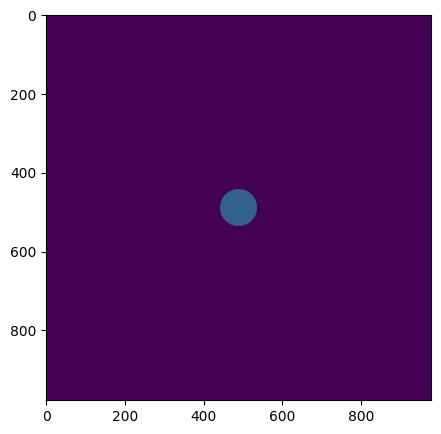

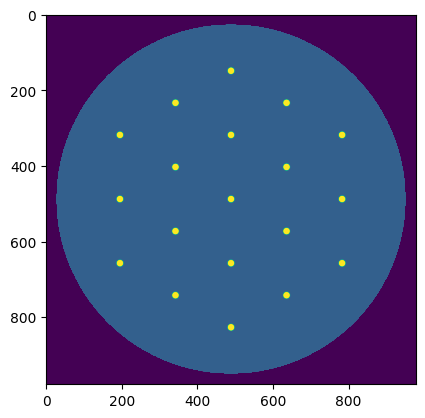

launch field


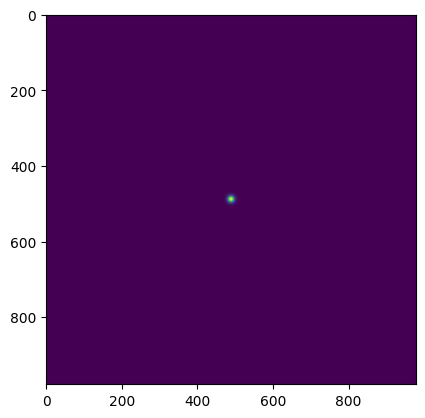

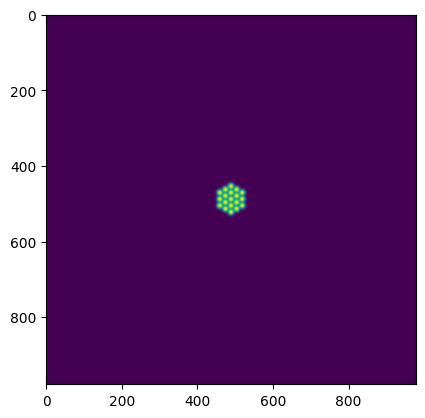

final field power decomposition:
mode0:  0.48144255701527894
mode1:  0.003747431484357703
mode2:  0.0037473525944218644
mode3:  0.00374723281378928
mode4:  0.003747204688541495
mode5:  0.0037472405567723567
mode6:  0.00374736346688244
mode7:  7.613133913623305e-08
mode8:  1.4828077820851464e-06
mode9:  7.612450717433108e-08
mode10:  1.4827903112116595e-06
mode11:  7.612525796712302e-08
mode12:  1.48286745335392e-06
mode13:  7.612602364107108e-08
mode14:  1.482840918309095e-06
mode15:  7.61286013085893e-08
mode16:  1.482936708534974e-06
mode17:  7.612937174602933e-08
mode18:  1.482775073078438e-06
total power in SMFs:  0.5039357364033915
Absolute values of u0 at lantern positions: 0.09941190433029917


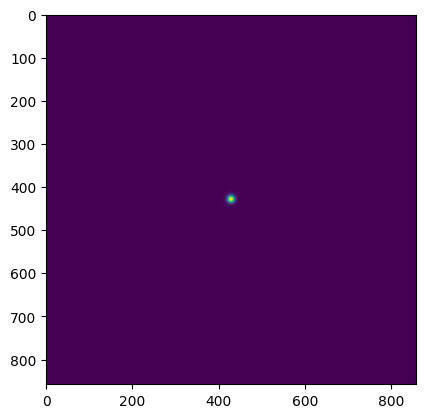

xg shape: (858, 858), yg shape: (858, 858)
(978, 978)
Initial u0 shape: (858, 858)
xa_in shape: (858,), ya_in shape: (858,)


In [4]:
''' example script for running the beamprop code in prop.py'''
import numpy as np
import sys
sys.path.append("../src")
import lightbeam
from lightbeam.mesh import RectMesh3D
from lightbeam.prop import Prop3D
from lightbeam.misc import normalize,overlap_nonu,norm_nonu
from lightbeam import LPmodes
import matplotlib.pyplot as plt
from config_example import *

# wl = 1.5 # um
# njack = 1.4345
# nclad = 1.44
# ncore = 1.4522895
# mm_rjack = 76.3 # um
# mm_rclad = 32.8 # um
# taper_ratio = 2.125
# sm_rcore = 6.5/10*taper_ratio # um
# mm_rjack = 76.3 # um
# sm_rclad = 32.8 # um
# # sm_seperation_final = 2*6.5
# sm_seperation_final = 2*6*taper_ratio # um
# sm_offset = 0 # um
# sm_ex = 5000 # um
# scale_func = None
# l = 0
# m = 1

wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
# sm_seperation_final = 2*6.5
sm_seperation_final = 2*60 # um
sm_offset = 500 # um
sm_ex = 40000 # um
scale_func = None
l = 0
m = 1

xw_func = None
yw_func = None
max_remesh_iters = 10
sig_max = 1.0
wl0 = 1.55
monitor_func = None
writeto = None
ref_val = 2e-3
remesh_every = 100
dynamic_n0 = False
fplanewidth = 10
xpos = [0]
ypos = [0]
di = 0.7 # 0.5 - 0.6 - 0.7 - 0.8 - 0.9 - 1
iw0 = 600
dz = 10 # 10 - 20 - 35 - 50 - 65 - 100
zw = sm_ex
num_PML = int(round(iw0/10))

lant19_ipos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final/taper_ratio)
lant19_fpos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,sm_offset,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics.scaled_cyl(xy=lant19_ipos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=sm_offset,scale_func=scale_func,final_scale=taper_ratio) # fxy=lant19_fpos[i]
    elmnts.append(core)

optic = optics.OpticSys(elmnts,njack)


mesh = RectMesh3D(iw0,iw0,zw,di,dz,num_PML,xw_func,yw_func)
xg0,yg0 = mesh.xy.xg,mesh.xy.yg
xg, yg = mesh.xg[num_PML:-num_PML,num_PML:-num_PML],mesh.yg[num_PML:-num_PML,num_PML:-num_PML]
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,sm_rcore,wl,nclad,njack))

optic.set_sampling(mesh.xy)
out = np.zeros(mesh.xy.shape)

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
# Generate the first subplot
optic.set_IORsq(out, 0)
plt.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
plt.show()
out = np.zeros(mesh.xy.shape)
optic.set_IORsq(out, sm_ex)
plt.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
plt.show()
mesh.xy.max_iters = max_remesh_iters
mesh.sigma_max = sig_max

# propagator initialization (required)
prop = Prop3D(wl0,mesh,optic,nclad)
u0 = normalize(LPmodes.lpfield(xg0,yg0,l,m,sm_rcore,wl,nclad,njack))
print('launch field')
plt.imshow(np.real(u0))
plt.show()
w = mesh.xy.get_weights()

modes = []
sumofmodes = 0
for x,y in lant19_ipos:
    mode = norm_nonu(LPmodes.lpfield(xg0-x,yg0-y,0,1,sm_rcore,wl0,ncore,nclad),w) # Change this for each mode

    sumofmodes += mode
    modes.append(mode)
plt.imshow(np.abs(sumofmodes))
plt.show()
SMFpower=0
print("final field power decomposition:")
for i in range(len(modes)):
    _p = np.power(overlap_nonu(u0,modes[i],w),2)
    print("mode"+str(i)+": ", _p)
    SMFpower += _p

print("total power in SMFs: ", SMFpower)

abs_u0_at_positions = []
for x, y in lant19_ipos:
    # Find the nearest grid point index
    ix = np.argmin(np.abs(mesh.xy.xa0 - x))
    iy = np.argmin(np.abs(mesh.xy.ya0 - y))
    abs_u0_at_positions.append(np.abs(u0[ix, iy]))

print("Absolute values of u0 at lantern positions:", np.sum(abs_u0_at_positions))
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,sm_rcore,wl,nclad,njack))
plt.imshow(abs(u0))
plt.show()
print(f"xg shape: {xg.shape}, yg shape: {yg.shape}")
print(mesh.xy.shape)
print(f"Initial u0 shape: {u0.shape}")
xa_in, ya_in = xg[:, 0], yg[0, :]
print(f"xa_in shape: {xa_in.shape}, ya_in shape: {ya_in.shape}")


In [30]:

# run the propagator (required)
ux, u0 = prop.prop2end(u0, monitor_func=monitor_func,xyslice=None,zslice=None,writeto=writeto,ref_val=ref_val,remesh_every=remesh_every,dynamic_n0=dynamic_n0,fplanewidth=fplanewidth)
#u0 = prop.prop2end_uniform(u0)
# u, u0 ^^
# compute power in output ports (optional)


input power:  0.9999999999999993
propagating field...
initial shape:  (1527, 1527)


KeyboardInterrupt: 

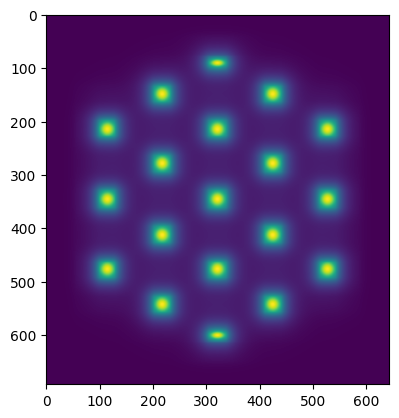

final field power decomposition:
mode0:  0.027826718099236956
mode1:  0.1352900269433173
mode2:  0.15838973731514294
mode3:  0.15838973731514455
mode4:  0.13529002694332457
mode5:  0.15838973731515085
mode6:  0.15838973731514827
mode7:  0.004550434331452504
mode8:  0.1028843324396417
mode9:  0.01336568003056341
mode10:  0.08828357165204458
mode11:  0.013365680030563737
mode12:  0.1028843324396523
mode13:  0.0045504343314534046
mode14:  0.10288433243965382
mode15:  0.013365680030565557
mode16:  0.08828357165204945
mode17:  0.013365680030565232
mode18:  0.10288433243964261
total power in SMFs:  1.5826337830943134
(341, 341)
Absolute values of u0 at lantern positions: 1.1422521373045005
0.08060596476858749
0.0735038967035281
0.076847659452144
0.07741914326858908
0.07350389670352907
0.07684765945214451
0.07684765945214433
0.024091010393158703
0.07161367926470477
0.03412053135006964
0.06784659354453523
0.034120531350069316
0.0716136792647076
0.024091010393156947
0.07161367926470898
0.034120

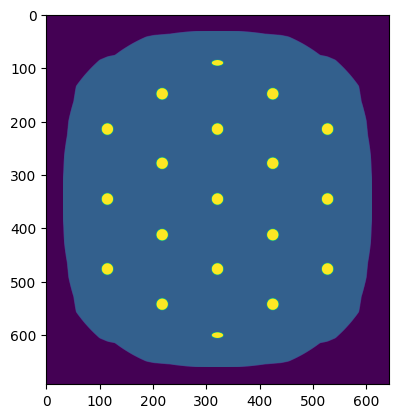

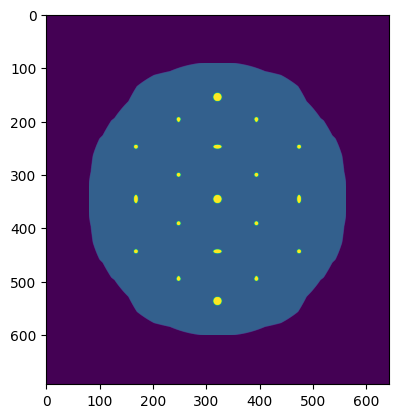

final field dist:


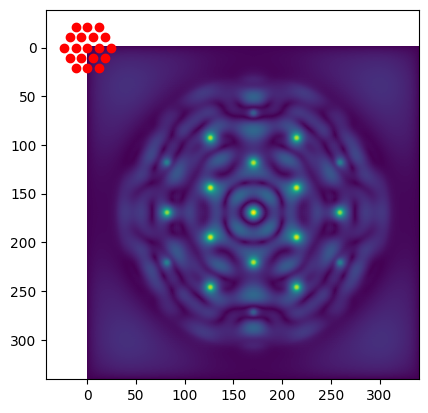

In [58]:
u = ux
xg,yg = np.meshgrid(mesh.xy.xa,mesh.xy.ya,indexing='ij')

w = mesh.xy.get_weights()

xg0,yg0 = np.meshgrid(mesh.xy.xa0,mesh.xy.ya0,indexing='ij')
w0 = mesh.xy.dx0*mesh.xy.dy0

modes = []
sumofmodes = 0
for x,y in lant19_fpos:
    mode = norm_nonu(LPmodes.lpfield(xg-x,yg-y,0,1,sm_rcore,wl0,ncore,nclad),w) # Change this for each mode
    sumofmodes += mode
    modes.append(mode)
plt.imshow(np.abs(sumofmodes))
plt.show()
SMFpower=0
print("final field power decomposition:")
for i in range(len(modes)):
    _p = np.power(overlap_nonu(u,modes[i],w),2)
    print("mode"+str(i)+": ", _p)
    SMFpower += _p

print("total power in SMFs: ", SMFpower)

print(u0.shape)
abs_u0_at_positions = []
for x, y in lant19_fpos:
    # Find the nearest grid point index
    ix = np.argmin(np.abs(mesh.xy.xa0 - x))
    iy = np.argmin(np.abs(mesh.xy.ya0 - y))
    abs_u0_at_positions.append(np.abs(u0[ix, iy]))
print("Absolute values of u0 at lantern positions:", np.sum(abs_u0_at_positions))
for x, y in lant19_fpos:
    # Find the nearest grid point index
    ix = np.argmin(np.abs(mesh.xy.xa0 - x))
    iy = np.argmin(np.abs(mesh.xy.ya0 - y))
    print(np.abs(u0[ix, iy]))

out = np.zeros(mesh.xy.shape)
optic.set_IORsq(out, sm_ex)
plt.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
plt.show()
out = np.zeros(mesh.xy.shape)
optic.set_IORsq(out, sm_ex/2)
plt.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
plt.show()
# plotting (optional)
print("final field dist:")
plt.imshow(np.abs(u0)) 
plt.plot([pos[0] for pos in lant19_ipos], [pos[1] for pos in lant19_ipos], 'ro', label='Positions')
plt.show()

In [2]:
import numpy as np
import sys
sys.path.append("../src")
import os
import time
import json
import lightbeam
from lightbeam.mesh import RectMesh3D
from lightbeam.prop import Prop3D
from lightbeam.misc import normalize, overlap_nonu, norm_nonu
from lightbeam import LPmodes
import matplotlib.pyplot as plt
from config_example import *

In [3]:
def save_results(folder, di, dz, initial_conditions, input_light_real, input_light_imag, powers, abs_u0_at_positions, abs_u0_final_positions, outputs_real, outputs_imag, runtimes):
    if not os.path.exists(folder):
        os.makedirs(folder)
    results = {
        "di": di,
        "dz": dz,
        "initial_conditions": initial_conditions,
        "input_light_real": input_light_real,
        "input_light_imag": input_light_imag,
        "powers": powers,
        "abs_u0_at_positions": abs_u0_at_positions,
        "abs_u0_final_positions": abs_u0_final_positions,
        "outputs_real": outputs_real,
        "outputs_imag": outputs_imag,
        "runtimes": runtimes
    }
    with open(f"{folder}/results_di_{di}_dz_{dz}.json", "w") as f:
        json.dump(results, f, indent=4)

In [4]:
# wl = 1.5 # um
# njack = 1.4345
# nclad = 1.44
# ncore = 1.4522895
# mm_rjack = 76.3 # um
# mm_rclad = 32.8 # um
# taper_ratio = 2.125
# sm_rcore = 6.5 / 10 * taper_ratio # um
# mm_rjack = 76.3 # um
# sm_rclad = 32.8 # um
# sm_seperation_final = 2 * 6 * taper_ratio # um
# sm_offset = 0 # um
# sm_ex = 5000 # um
# scale_func = None
# l = 0
# m = 1

wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_final = 2 * 60 # um
sm_offset = 500 # um
sm_ex = 40000 # um
scale_func = None
l = 0
m = 1

xw_func = None
yw_func = None
max_remesh_iters = 10
sig_max = 1.0
wl0 = 1.55
monitor_func = None
writeto = None
ref_val = 2e-3
remesh_every = 100
dynamic_n0 = False
fplanewidth = 10
xpos = [0]
ypos = [0]
zw = sm_ex

# Define the range of di and dz values for the grid search
di_values = [1,0.5, 0.6, 0.7, 0.8, 0.9, 1]
dz_values = [100, 20, 35, 50, 65, 80, 100]
results_folder = "grid_search_results"

In [5]:
# Initial setup for optics
lant19_ipos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final / taper_ratio)
lant19_fpos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0, 0], sm_rclad, sm_ex, nclad, njack, sm_offset, scale_func=scale_func, final_scale=taper_ratio)
elmnts = [clad_mm,clad_sm]
for i in range(len(lant19_ipos)):
    core = optics.scaled_cyl(xy=lant19_ipos[i], r=sm_rcore / taper_ratio, z_ex=sm_ex, n=ncore, nb=nclad, z_offset=sm_offset, scale_func=scale_func, final_scale=taper_ratio)
    elmnts.append(core)
optic = optics.OpticSys(elmnts, njack)

In [6]:
# for di in di_values:
#     for dz in dz_values:
#         print(di, dz)
#         iw0 = int(round(300 / di))
#         num_PML = int(round(iw0 / 9))
#         print(iw0, num_PML)

#         mesh = RectMesh3D(iw0, iw0, zw, di, dz, num_PML, xw_func, yw_func)
#         xg0, yg0 = mesh.xy.xg, mesh.xy.yg
#         xg, yg = mesh.xg[num_PML:-num_PML, num_PML:-num_PML], mesh.yg[num_PML:-num_PML, num_PML:-num_PML]
#         u0 = normalize(LPmodes.lpfield(xg, yg, l, m, sm_rcore, wl, nclad, njack))

#         optic.set_sampling(mesh.xy)
#         out = np.zeros(mesh.xy.shape)

#         # Save initial conditions
#         initial_conditions = {
#             "l": l,
#             "m": m,
#             "di": di,
#             "dz": dz,
#             "mesh_shape": mesh.xy.shape,
#             "njack": njack,
#             "nclad": nclad,
#             "ncore": ncore,
#             "sm_rcore": sm_rcore,
#             "sm_rclad": sm_rclad,
#             "taper_ratio": taper_ratio,
#             "sm_seperation_final": sm_seperation_final,
#             "sm_offset": sm_offset,
#             "sm_ex": sm_ex
#         }

#         # Initialize propagator
#         prop = Prop3D(wl0, mesh, optic, nclad)
#         u0 = (1 + 0j) * normalize(LPmodes.lpfield(xg0, yg0, l, m, sm_rcore, wl, nclad, njack))

#         w = mesh.xy.get_weights()

#         # Save input light (real and imaginary parts separately)
#         input_light_real = np.real(u0).tolist()
#         input_light_imag = np.imag(u0).tolist()

#         modes_before = []
#         sumofmodes_before = 0
#         for x, y in lant19_ipos:
#             mode = norm_nonu(LPmodes.lpfield(xg0 - x, yg0 - y, l, m, sm_rcore, wl0, ncore, nclad), w)
#             sumofmodes_before += mode
#             modes_before.append(mode.tolist())

#         SMFpower_before = 0
#         for i in range(len(modes_before)):
#             _p = np.power(overlap_nonu(u0, np.array(modes_before[i]), w), 2)
#             SMFpower_before += _p

#         abs_u0_at_positions = []
#         for x, y in lant19_ipos:
#             ix = np.argmin(np.abs(mesh.xy.xa0 - x))
#             iy = np.argmin(np.abs(mesh.xy.ya0 - y))
#             abs_u0_at_positions.append(np.abs(u0[ix, iy]))

#         u0 = (1 + 0j) * normalize(LPmodes.lpfield(xg, yg, l, m, sm_rcore, wl, nclad, njack))
#         print(u0.shape)

#         # Propagation
#         start_time = time.time()
#         ux, u0 = prop.prop2end(u0, monitor_func=monitor_func, xyslice=None, zslice=None, writeto=writeto, ref_val=ref_val, remesh_every=remesh_every, dynamic_n0=dynamic_n0, fplanewidth=fplanewidth)
#         end_time = time.time()
#         runtime = end_time - start_time

#         # Save outputs (real and imaginary parts separately)
#         outputs_real = np.real(u0).tolist()
#         outputs_imag = np.imag(u0).tolist()

#         xg,yg = np.meshgrid(mesh.xy.xa,mesh.xy.ya,indexing='ij')
#         w = mesh.xy.get_weights()

#         xg0,yg0 = np.meshgrid(mesh.xy.xa0,mesh.xy.ya0,indexing='ij')
#         w0 = mesh.xy.dx0*mesh.xy.dy0

#         # Calculate final power decomposition
#         modes_after = []
#         sumofmodes_after = 0
#         for x, y in lant19_fpos:
#             mode = norm_nonu(LPmodes.lpfield(xg - x, yg - y, 0, 1, sm_rcore, wl0, ncore, nclad), w)
#             sumofmodes_after += mode
#             modes_after.append(mode.tolist())

#         SMFpower_after = 0
#         powers = []
#         for i in range(len(modes_after)):
#             _p = np.power(overlap_nonu(ux, np.array(modes_after[i]), w), 2)
#             powers.append(_p)
#             SMFpower_after += _p

#         abs_u0_final_positions = []
#         for x, y in lant19_fpos:
#             ix = np.argmin(np.abs(mesh.xy.xa0 - x))
#             iy = np.argmin(np.abs(mesh.xy.ya0 - y))
#             abs_u0_final_positions.append(np.abs(u0[ix, iy]))

#         # print("di:", type(di))
#         # print("dz:", type(dz))
#         # print("initial_conditions:", {k: type(v) for k, v in initial_conditions.items()})
#         # print("input_light_real:", type(input_light_real),type(input_light_real[0]), type(input_light_real[0][0]))
#         # print("input_light_imag:", type(input_light_imag), type(input_light_imag[0]), type(input_light_imag[0][0]))
#         # print("powers:", type(powers), type(powers[0]))
#         # # print("modes_before:", type(modes_before), type(modes_before[0]), type(modes_before[0][0]), type(modes_before[0][0][0]))
#         # # print("modes_after:", type(modes_after), type(modes_after[0]), type(modes_after[0][0]), type(modes_after[0][0][0]))
#         # print("abs_u0_at_positions:", type(abs_u0_at_positions), type(abs_u0_at_positions[0]))
#         # print("abs_u0_final_positions:", type(abs_u0_final_positions), type(abs_u0_final_positions[0]))
#         # print("outputs_real:", type(outputs_real), type(outputs_real[0]), type(outputs_real[0][0]))
#         # print("outputs_imag:", type(outputs_imag), type(outputs_imag[0]), type(outputs_imag[0][0]))
#         # print("runtime:", type(runtime))

#         # Save the results
#         save_results(results_folder, di, dz, initial_conditions, input_light_real, input_light_imag, powers, abs_u0_at_positions, abs_u0_final_positions, outputs_real, outputs_imag, runtime)
#         print("Saved!")

# print("Grid search completed.")

Trying di=1, dz=100, attempt 1
600
67


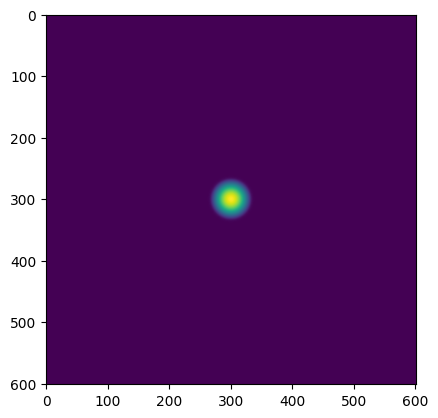

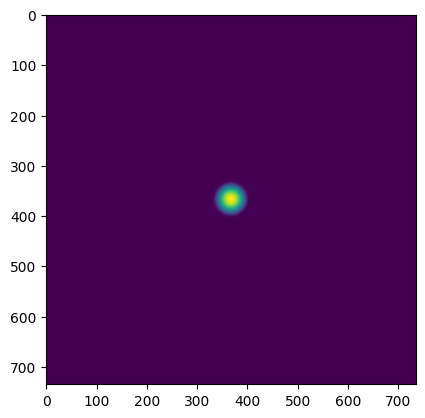

[[7.98585559e-165+0.j 1.36821023e-164+0.j 2.34241869e-164+0.j ...
  2.34241869e-164+0.j 1.36821023e-164+0.j 7.98585559e-165+0.j]
 [1.36821023e-164+0.j 2.34586947e-164+0.j 4.01916279e-164+0.j ...
  4.01916279e-164+0.j 2.34586947e-164+0.j 1.36821023e-164+0.j]
 [2.34241869e-164+0.j 4.01916279e-164+0.j 6.89108893e-164+0.j ...
  6.89108893e-164+0.j 4.01916279e-164+0.j 2.34241869e-164+0.j]
 ...
 [2.34241869e-164+0.j 4.01916279e-164+0.j 6.89108893e-164+0.j ...
  6.89108893e-164+0.j 4.01916279e-164+0.j 2.34241869e-164+0.j]
 [1.36821023e-164+0.j 2.34586947e-164+0.j 4.01916279e-164+0.j ...
  4.01916279e-164+0.j 2.34586947e-164+0.j 1.36821023e-164+0.j]
 [7.98585559e-165+0.j 1.36821023e-164+0.j 2.34241869e-164+0.j ...
  2.34241869e-164+0.j 1.36821023e-164+0.j 7.98585559e-165+0.j]]
[[7.99765551e-165+0.j 1.37021429e-164+0.j 2.34581975e-164+0.j ...
  2.34581975e-164+0.j 1.37021429e-164+0.j 7.99765551e-165+0.j]
 [1.37024937e-164+0.j 2.34933517e-164+0.j 4.02504867e-164+0.j ...
  4.02504867e-164+0.j 2.3

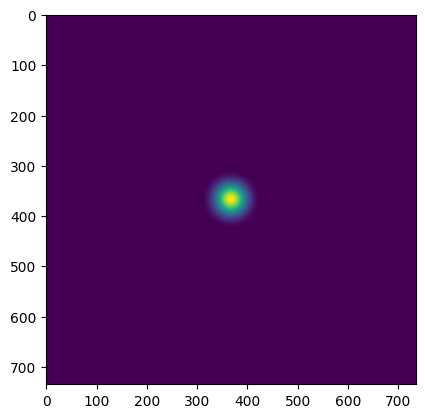

0.9992919874792893
1.7219701815916295
2.4446488428481903
3.167327504104751
3.890005698217091
4.6126843594736515
5.335363020730212
5.611327152569162
5.9927764766759735
6.268740252284776
6.650189424740114
6.926153200348917
7.30760252445573
7.583566656294678
7.96501598040149
8.240979756010292
8.622428928465629
8.898392704074432
9.279842028181243
0.03130976092611942
0.026126939171261847
0.026403052655757958
0.026403052655757958
0.026126939171261847
0.026403052655757958
0.026403052655757958
0.013127556360317837
0.017290327432262265
0.012894229183434622
0.016803496365002207
0.012894229183434622
0.017290327432262265
0.013127556360317837
0.017290327432262265
0.012894229183434622
0.016803496365002207
0.012894229183434622
0.017290327432262265
(601, 601)


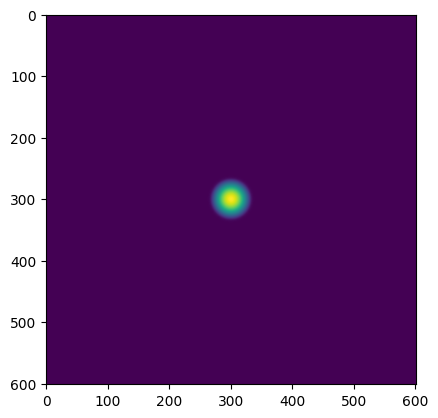

input power:  1.0000000000000002
propagating field...
initial shape:  (821, 821)


KeyboardInterrupt: 

In [6]:
for di in di_values:
    for dz in dz_values:
        success = False
        retry_count = 0
        additional = 0
        while not success and retry_count < 5:
            try:
                print(f"Trying di={di}, dz={dz}, attempt {retry_count + 1}")
                iw0 = 600 + additional
                num_PML = int(round(iw0 /9)) + additional
                print(iw0)
                print(num_PML)
                mesh = RectMesh3D(iw0, iw0, zw, di, dz, num_PML, xw_func, yw_func)
                xg0, yg0 = mesh.xy.xg, mesh.xy.yg
                xg, yg = mesh.xg[num_PML:-num_PML, num_PML:-num_PML], mesh.yg[num_PML:-num_PML, num_PML:-num_PML]
                u0 = (1+0j) * normalize(LPmodes.lpfield(xg, yg, l, m, mm_rclad, wl, nclad, njack))
                plt.imshow(np.abs(u0))
                plt.show()
                optic.set_sampling(mesh.xy)
                out = np.zeros(mesh.xy.shape)

                # Save initial conditions
                initial_conditions = {
                    "l": l,
                    "m": m,
                    "di": di,
                    "dz": dz,
                    "mesh_shape": mesh.xy.shape,
                    "njack": njack,
                    "nclad": nclad,
                    "ncore": ncore,
                    "sm_rcore": sm_rcore,
                    "sm_rclad": sm_rclad,
                    "taper_ratio": taper_ratio,
                    "sm_seperation_final": sm_seperation_final,
                    "sm_offset": sm_offset,
                    "sm_ex": sm_ex
                }

                # Initialize propagator
                prop = Prop3D(wl0, mesh, optic, nclad)
                u0 = (1+0j) *normalize(LPmodes.lpfield(xg0, yg0, l, m, mm_rclad, wl, nclad, njack))
                plt.imshow(np.abs(u0))
                plt.show()
                w = mesh.xy.get_weights()

                # Save input light (real and imaginary parts separately)
                input_light_real = np.real(u0).tolist()
                input_light_imag = np.imag(u0).tolist()

                modes_before = []
                sumofmodes_before = 0
                for x, y in lant19_ipos:
                    mode = norm_nonu(LPmodes.lpfield(xg0 - x, yg0 - y, l, m, mm_rclad, wl0, ncore, nclad), w)
                    sumofmodes_before += mode
                    modes_before.append(mode.tolist())
                    print(sumofmodes_before)
                plt.imshow(np.abs(sumofmodes_before))
                plt.show()
                SMFpower_before = 0
                for i in range(len(modes_before)):
                    _p = np.power(overlap_nonu(u0, np.array(modes_before[i]), w), 2)
                    SMFpower_before += _p
                    print(SMFpower_before)

                abs_u0_at_positions = []
                for x, y in lant19_ipos:
                    ix = np.argmin(np.abs(mesh.xy.xa0 - x))
                    iy = np.argmin(np.abs(mesh.xy.ya0 - y))
                    abs_u0_at_positions.append(np.abs(u0[ix, iy]))
                    print(np.abs(u0[ix, iy]))
                u0 = normalize(LPmodes.lpfield(xg, yg, l, m, mm_rclad, wl, nclad, njack))
                print(u0.shape)
                plt.imshow(np.abs(u0))
                plt.show()
                # Propagation
                start_time = time.time()
                ux, u0 = prop.prop2end(u0, monitor_func=monitor_func, xyslice=None, zslice=None, writeto=writeto, ref_val=ref_val, remesh_every=remesh_every, dynamic_n0=dynamic_n0, fplanewidth=fplanewidth)
                end_time = time.time()
                runtime = end_time - start_time

                # Save outputs (real and imaginary parts separately)
                outputs_real = np.real(u0).tolist()
                outputs_imag = np.imag(u0).tolist()

                xg, yg = np.meshgrid(mesh.xy.xa, mesh.xy.ya, indexing='ij')
                w = mesh.xy.get_weights()

                xg0, yg0 = np.meshgrid(mesh.xy.xa0, mesh.xy.ya0, indexing='ij')
                w0 = mesh.xy.dx0 * mesh.xy.dy0

                # Calculate final power decomposition
                modes_after = []
                sumofmodes_after = 0
                for x, y in lant19_fpos:
                    mode = norm_nonu(LPmodes.lpfield(xg - x, yg - y, 0, 1, sm_rcore, wl0, ncore, nclad), w)
                    sumofmodes_after += mode
                    modes_after.append(mode.tolist())

                SMFpower_after = 0
                powers = []
                for i in range(len(modes_after)):
                    _p = np.power(overlap_nonu(ux, np.array(modes_after[i]), w), 2)
                    powers.append(_p)
                    SMFpower_after += _p

                abs_u0_final_positions = []
                for x, y in lant19_fpos:
                    ix = np.argmin(np.abs(mesh.xy.xa0 - x))
                    iy = np.argmin(np.abs(mesh.xy.ya0 - y))
                    abs_u0_final_positions.append(np.abs(u0[ix, iy]))

                # Save the results
                save_results(results_folder, di, dz, initial_conditions, input_light_real, input_light_imag, powers, abs_u0_at_positions, abs_u0_final_positions, outputs_real, outputs_imag, runtime)
                print("Saved!")
                success = True
            except Exception as e:
                print(f"Error with di={di}, dz={dz}, attempt {retry_count + 1}: {e}")
                additional += 20
                retry_count += 1
        if not success:
            print(f"Failed to process di={di}, dz={dz} after {retry_count} attempts")

In [1]:
import os
import json

def load_results(folder):
    results_list = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder, file_name)
            with open(file_path, 'r') as f:
                results = json.load(f)
                results_list.append(results)
    return results_list

results_folder = "grid_search_results_40000"
all_results = load_results(results_folder)

di: 0.5, dz: 100, runtime: 422.6556692123413, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 100, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


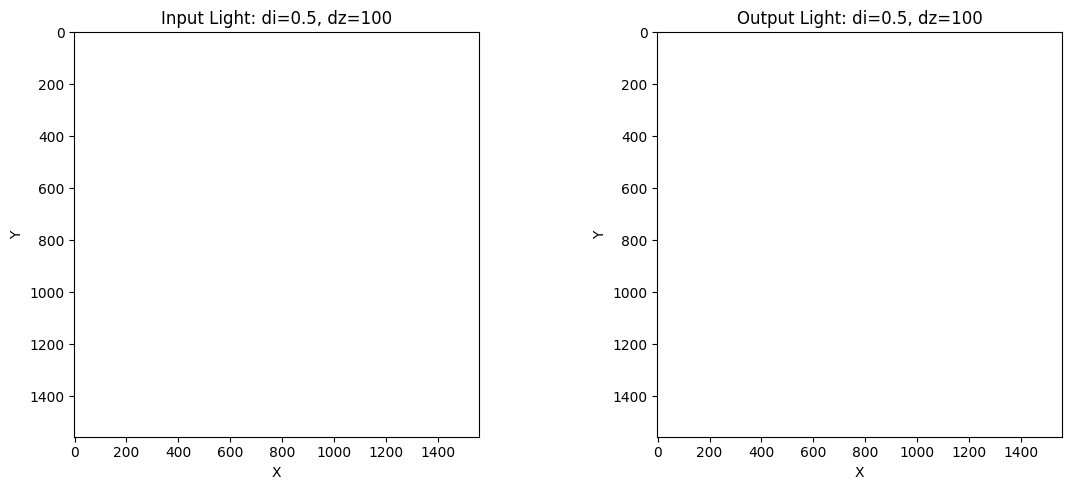

di: 0.5, dz: 20, runtime: 1946.5733716487885, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 20, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


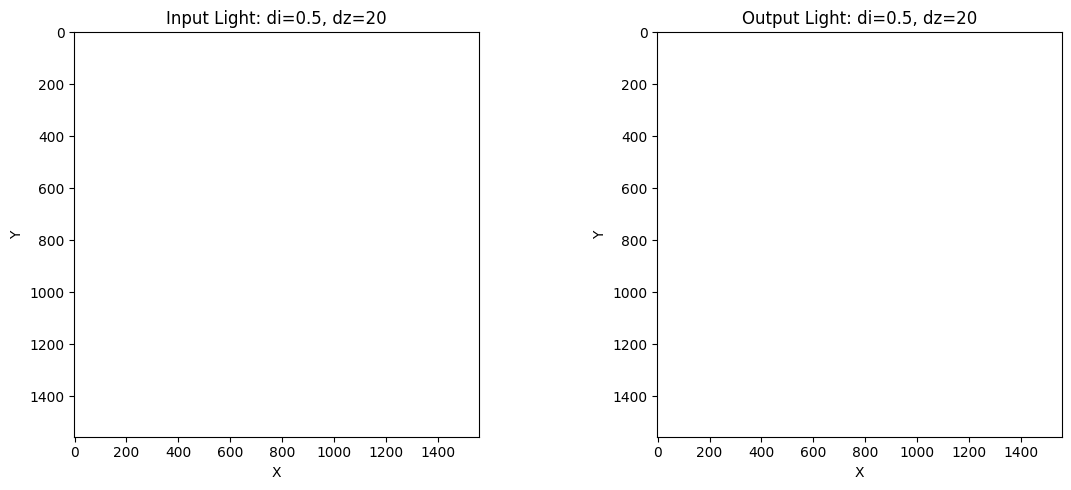

di: 0.5, dz: 35, runtime: 1016.9382765293121, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 35, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


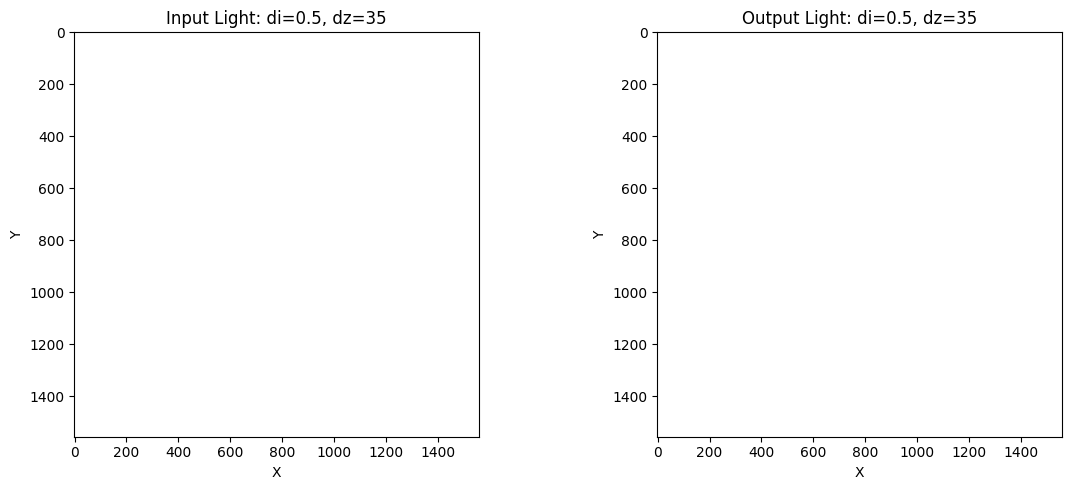

di: 0.5, dz: 50, runtime: 828.0877509117126, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 50, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


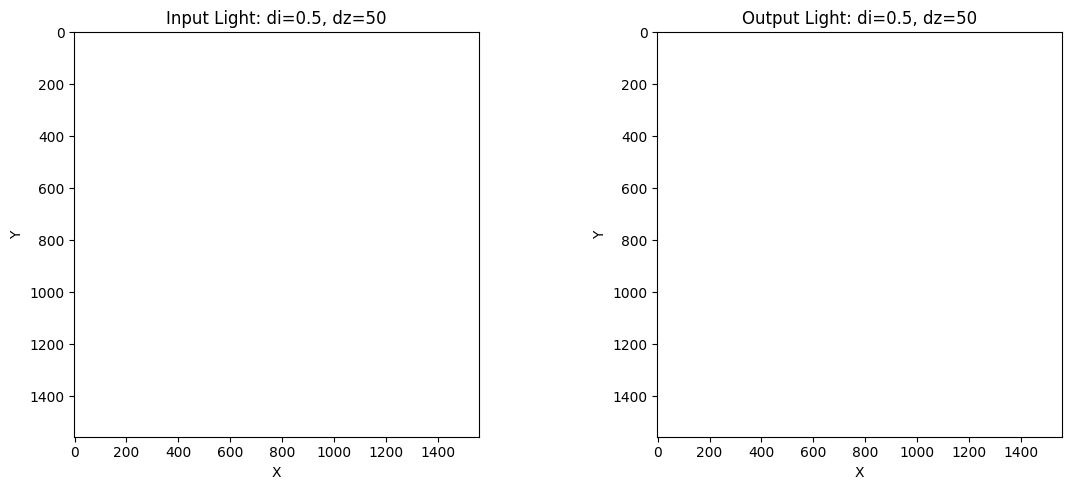

di: 0.5, dz: 65, runtime: 666.4194741249084, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 65, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


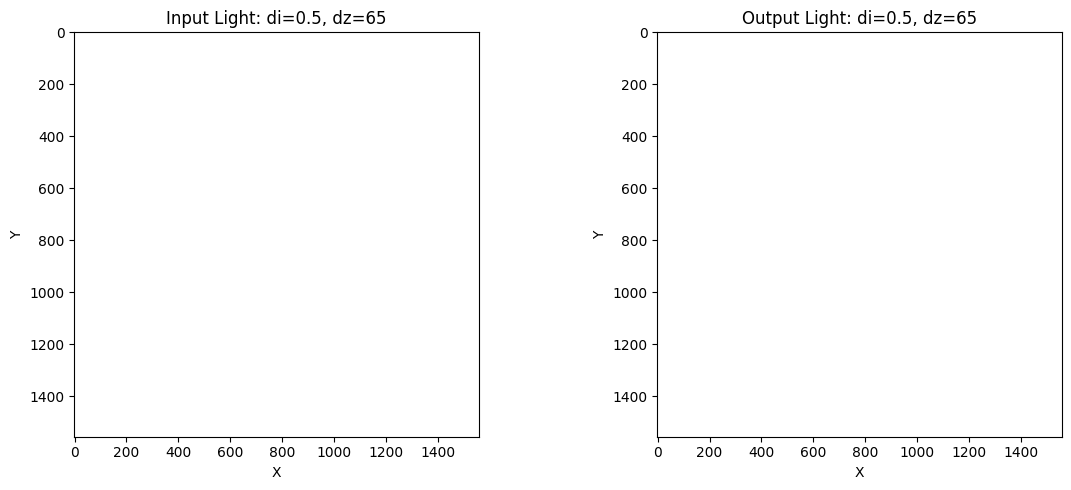

di: 0.5, dz: 80, runtime: 522.667263507843, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.5, 'dz': 80, 'mesh_shape': [1557, 1557], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


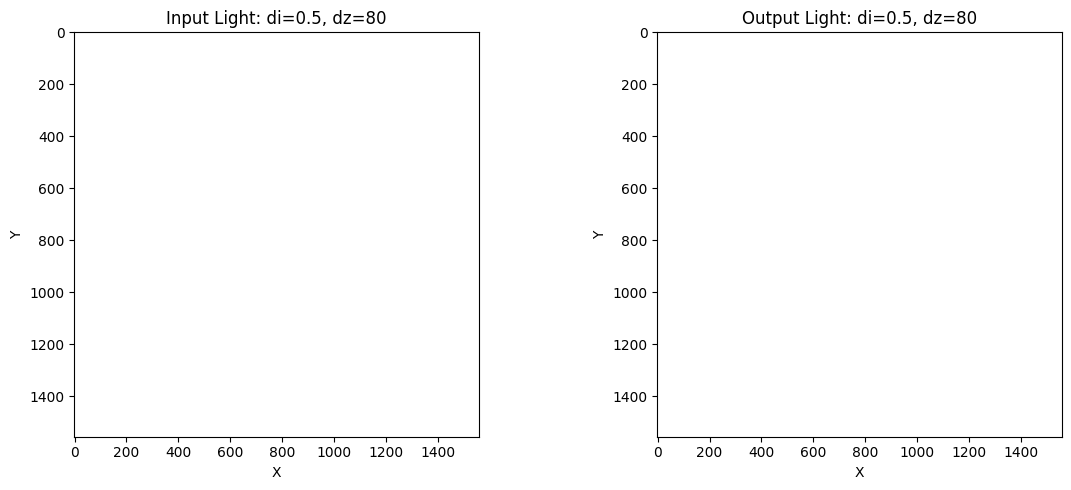

di: 0.6, dz: 100, runtime: 222.37557697296143, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 100, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


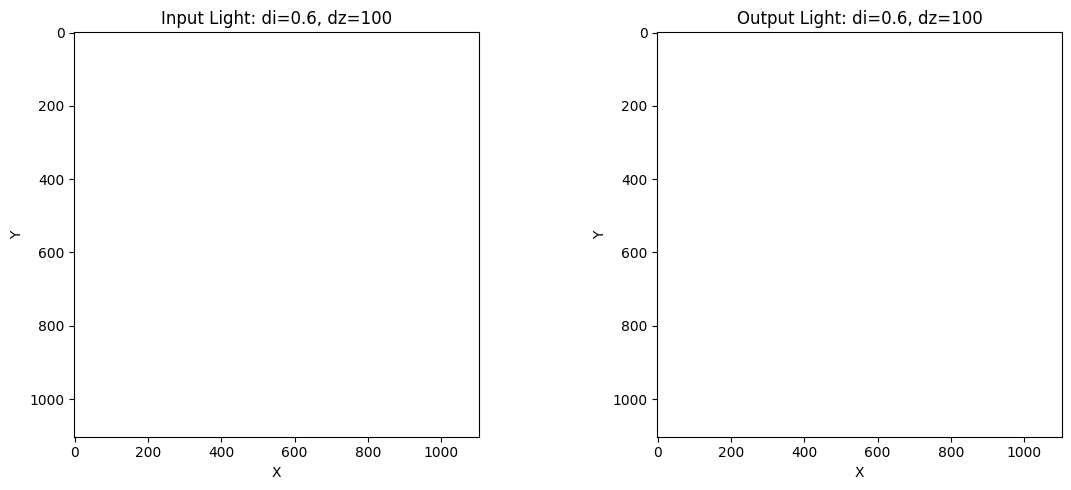

di: 0.6, dz: 20, runtime: 1114.9146401882172, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 20, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


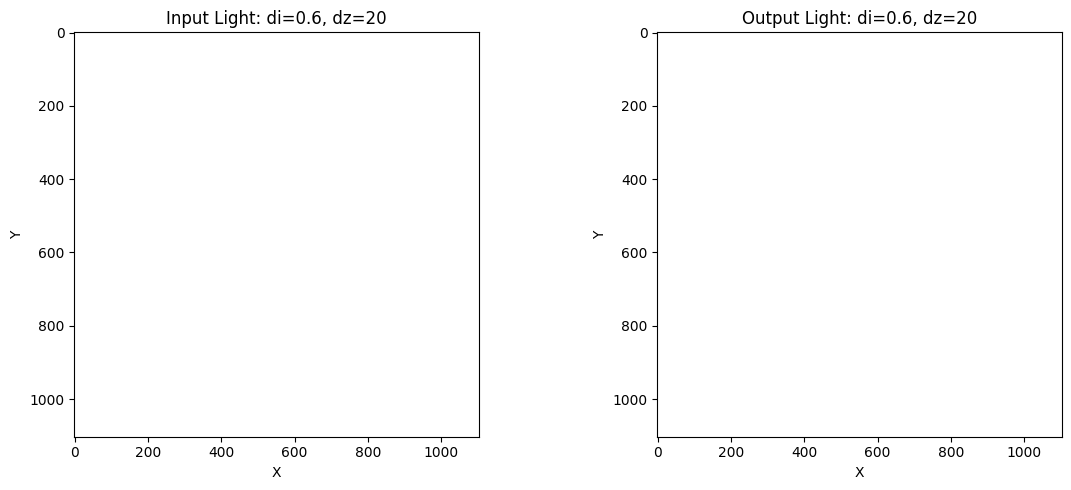

di: 0.6, dz: 35, runtime: 627.1088356971741, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 35, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


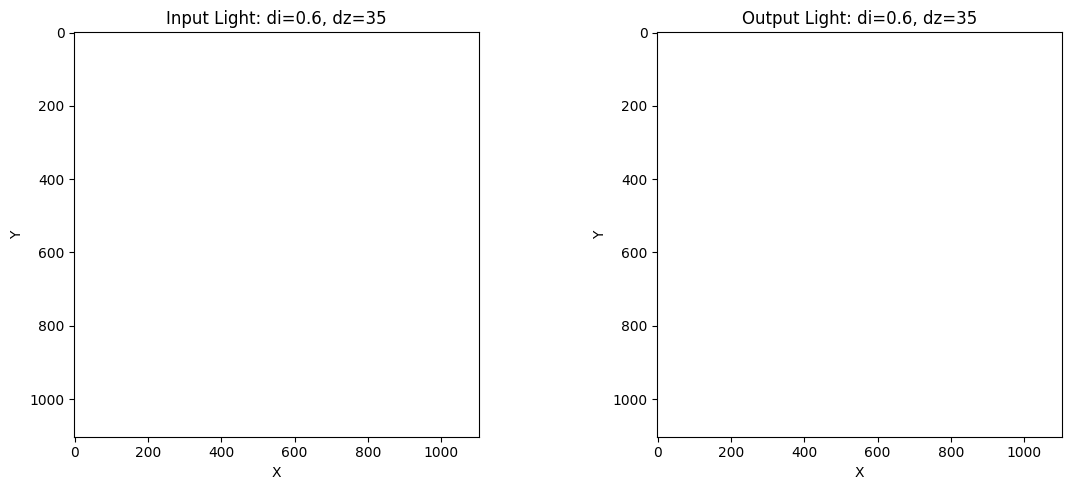

di: 0.6, dz: 50, runtime: 438.8715283870697, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 50, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


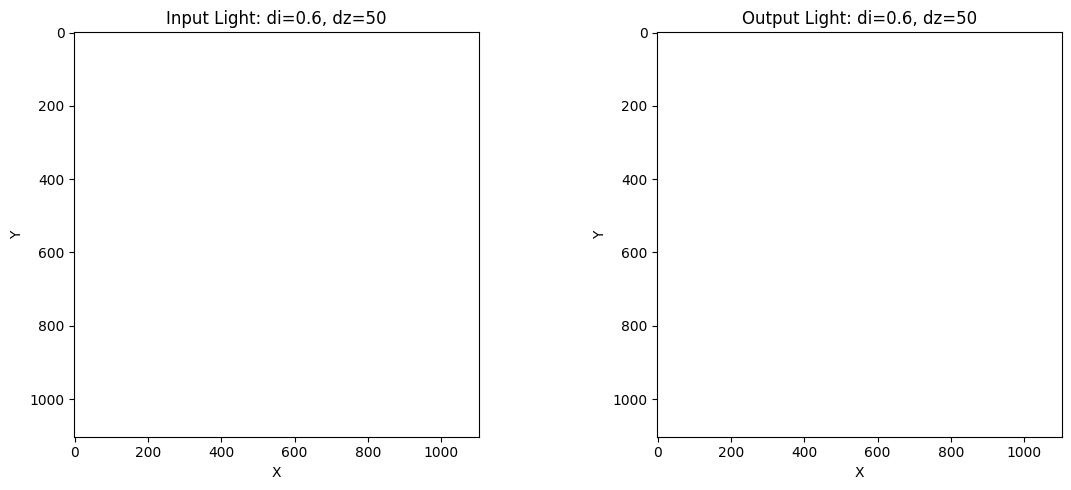

di: 0.6, dz: 65, runtime: 337.2602367401123, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 65, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


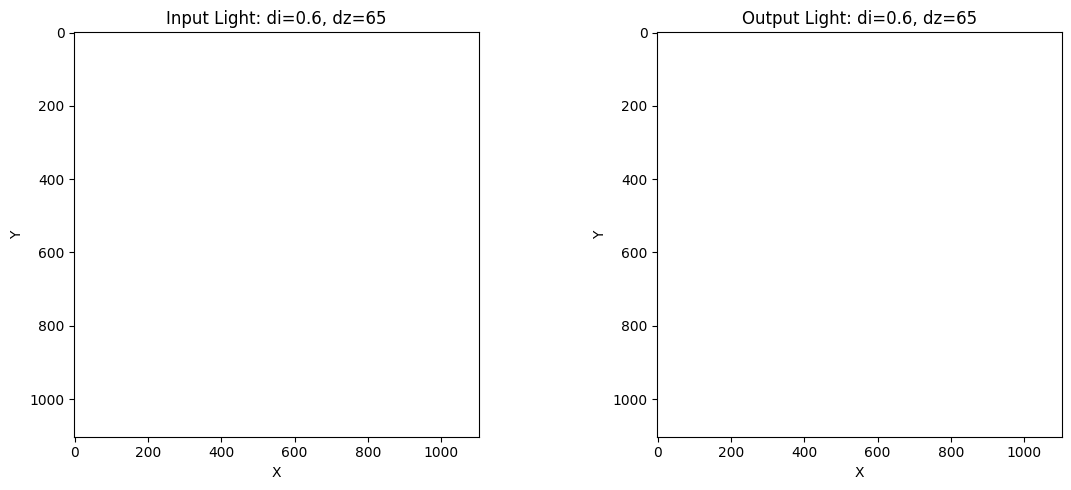

di: 0.6, dz: 80, runtime: 275.89653491973877, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.6, 'dz': 80, 'mesh_shape': [1103, 1103], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


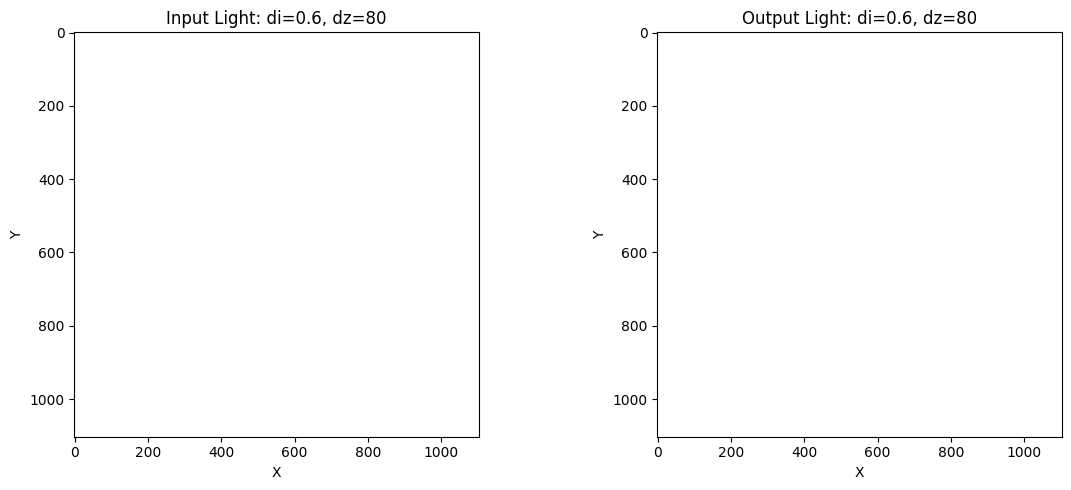

di: 0.7, dz: 100, runtime: 168.27548599243164, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 100, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


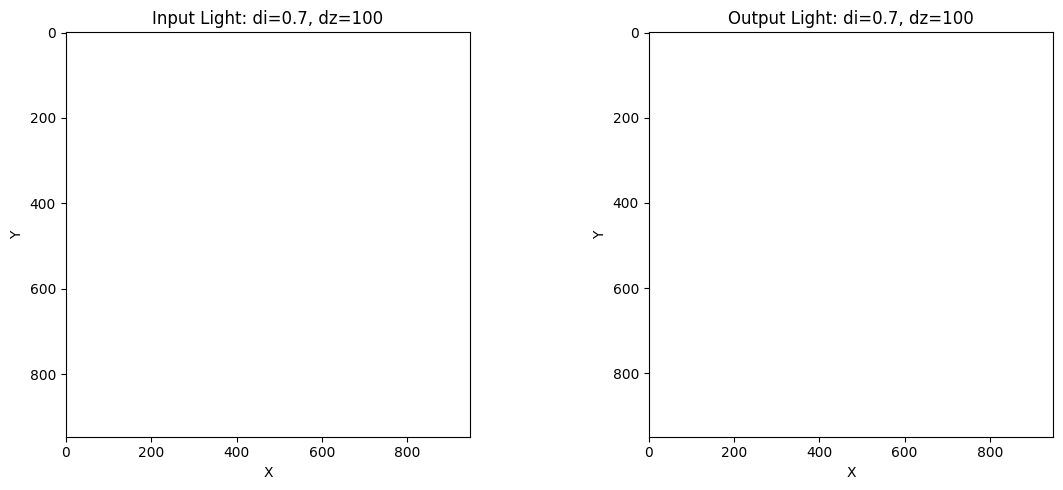

di: 0.7, dz: 20, runtime: 835.3602204322815, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 20, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


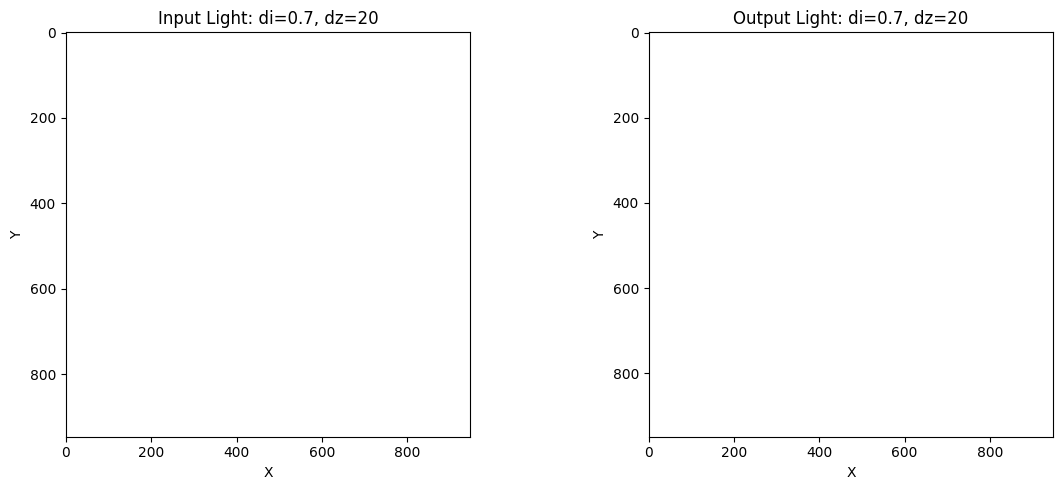

di: 0.7, dz: 35, runtime: 478.0362973213196, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 35, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


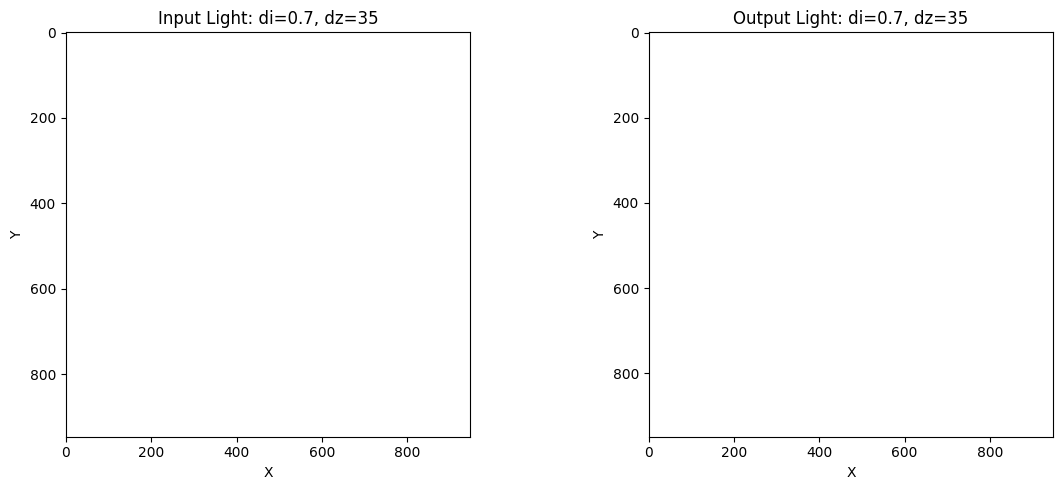

di: 0.7, dz: 50, runtime: 336.0179080963135, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 50, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


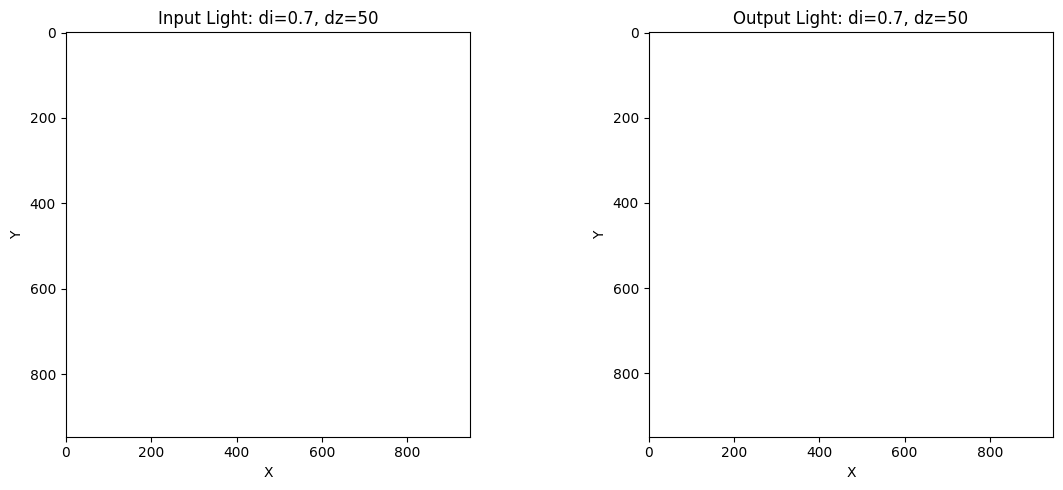

di: 0.7, dz: 65, runtime: 257.95274806022644, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 65, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


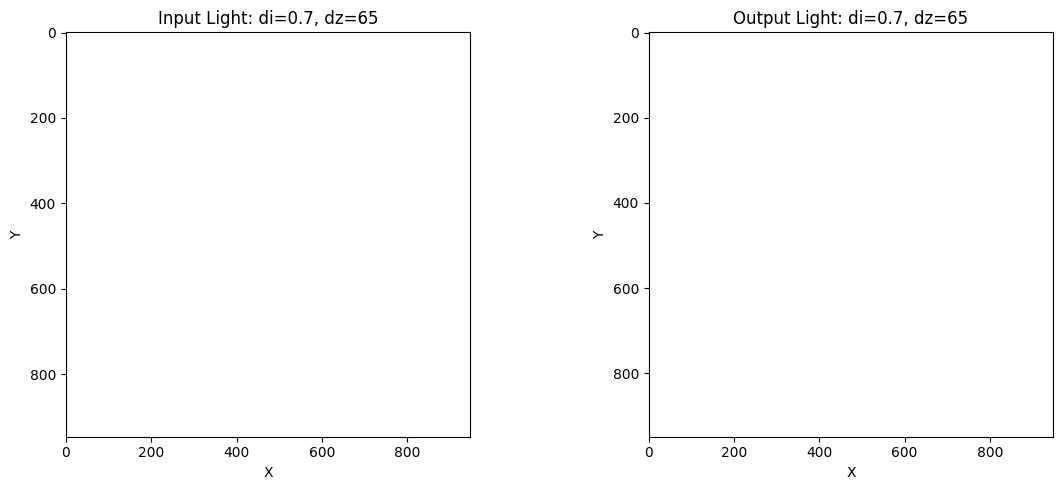

di: 0.7, dz: 80, runtime: 210.03809595108032, power: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
{'l': 2, 'm': 2, 'di': 0.7, 'dz': 80, 'mesh_shape': [947, 947], 'njack': 1.4345, 'nclad': 1.44, 'ncore': 1.4522895, 'sm_rcore': 6.5, 'sm_rclad': 32.8, 'taper_ratio': 10, 'sm_seperation_final': 120, 'sm_offset': 500, 'sm_ex': 40000}
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


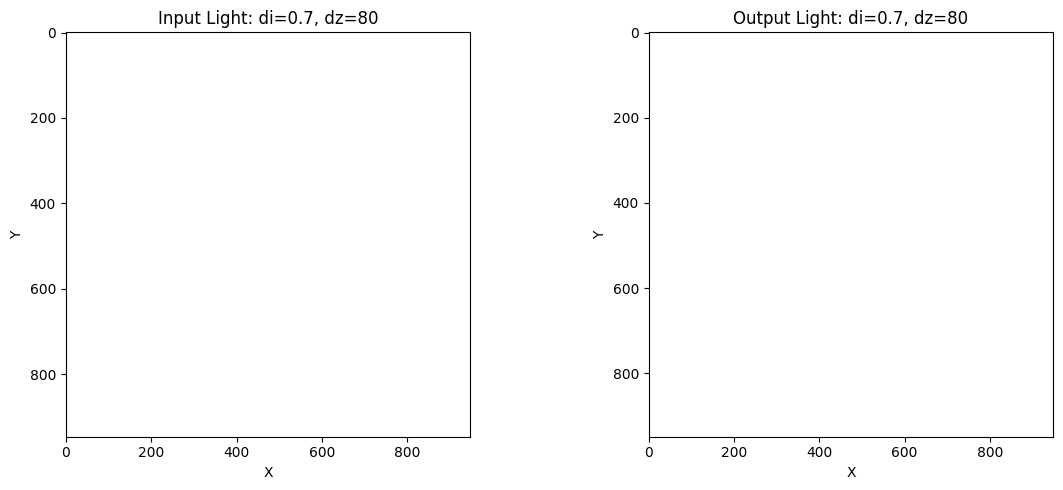

In [6]:
import numpy as np
import sys
sys.path.append("../src")
import lightbeam
from lightbeam.mesh import RectMesh3D
from lightbeam.prop import Prop3D
from lightbeam.misc import normalize,overlap_nonu,norm_nonu
from lightbeam import LPmodes
import matplotlib.pyplot as plt
from config_example import *
# Example analysis
for result in all_results:
    di = result["di"]
    dz = result["dz"]
    initial_conditions = result["initial_conditions"]
    input_light_real = result["input_light_real"]
    input_light_imag = result["input_light_imag"]
    powers = result["powers"]
    abs_u0_at_positions = result["abs_u0_at_positions"]
    abs_u0_final_positions = result["abs_u0_final_positions"]
    outputs_real = result["outputs_real"]
    outputs_imag = result["outputs_imag"]
    runtime = result["runtimes"]

    # Perform your analysis here
    print(f"di: {di}, dz: {dz}, runtime: {runtime}, power: {powers}")
    print(initial_conditions)
    
    # Convert lists to numpy arrays for plotting
    input_light_real = np.array(input_light_real)
    input_light_imag = np.array(input_light_imag)
    outputs_real = np.array(outputs_real)
    outputs_imag = np.array(outputs_imag)
    print(input_light_real)
    # Plotting input light
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Light: di={di}, dz={dz}")
    plt.imshow(np.sqrt(input_light_real**2 + input_light_imag**2))
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plotting output light
    plt.subplot(1, 2, 2)
    plt.title(f"Output Light: di={di}, dz={dz}")
    plt.imshow(np.sqrt(outputs_real**2 + outputs_imag**2))
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()
